# EDA 04 — Group comparisons (Full vs Pruned) with effect sizes and FDR

This notebook:
- Compares descriptor distributions across label groups
- Uses non-parametric tests by default:
  - 2 groups: Mann–Whitney U
  - >2 groups: Kruskal–Wallis
- Reports effect sizes:
  - 2 groups: Cliff's delta
  - >2 groups: epsilon-squared (ε²) from Kruskal–Wallis
- Applies multiple testing correction (Benjamini–Hochberg FDR)
- Runs the analysis for:
  - Full feature set (`feature_set_v1.csv`)
  - Pruned feature set derived from pruning recommendations (thr=0.80)
- Produces plots (volcano-style + top features)

Outputs:
- Tables: `results/eda/stats/`
- Figures: `results/eda/figures/group_comparisons/`


In [1]:
from __future__ import annotations

from pathlib import Path
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats


In [2]:
sns.set_context("notebook")
sns.set_style("whitegrid")

plt.rcParams["figure.dpi"] = 140
plt.rcParams["savefig.dpi"] = 300

PROJECT_ROOT = Path("../../").resolve()

DATA_PROCESSED_DIR = PROJECT_ROOT / "data" / "processed_variants"
STRICT_CSV  = DATA_PROCESSED_DIR / "hcs_strict_complete_case_20260129_114259.csv"
IMPUTED_CSV = DATA_PROCESSED_DIR / "hcs_imputed_exploratory_20260129_114259.csv"

EDA_ROOT = PROJECT_ROOT / "results" / "eda"
FIG_DIR = EDA_ROOT / "figures" / "group_comparisons"
STATS_DIR = EDA_ROOT / "stats"

FIG_DIR.mkdir(parents=True, exist_ok=True)
STATS_DIR.mkdir(parents=True, exist_ok=True)

print("FIG_DIR:", FIG_DIR)
print("STATS_DIR:", STATS_DIR)


FIG_DIR: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/group_comparisons
STATS_DIR: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/stats


In [3]:
def load_dataset(path: Path) -> pd.DataFrame:
    """
    Load a dataset from disk (CSV).

    Parameters
    ----------
    path : Path
        Path to a CSV file.

    Returns
    -------
    pd.DataFrame
        Loaded dataframe.
    """
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found: {path}")
    return pd.read_csv(path)

df_strict = load_dataset(STRICT_CSV)
df_imputed = load_dataset(IMPUTED_CSV)

print("STRICT:", df_strict.shape)
print("IMPUTED:", df_imputed.shape)

STRICT: (148, 15)
IMPUTED: (160, 15)


In [4]:
# ============================================================
# EXPLICIT COLUMN DEFINITIONS
# ============================================================

LABEL_COL = "MSPH"     

META_COLS = [
    "row_id", "_sheet", "LocalID"	
]

USE_AUTO_FEATURES = True
MANUAL_FEATURE_COLS: List[str] = []

# ============================================================

def resolve_columns(df: pd.DataFrame) -> tuple[str, List[str], List[str]]:
    """
    Resolve label, metadata and feature columns using explicit user definitions.

    Returns
    -------
    (label_col, meta_cols_present, feature_cols)
    """
    if LABEL_COL not in df.columns:
        raise ValueError(f"LABEL_COL='{LABEL_COL}' not found in dataframe columns.")

    meta_present = [c for c in META_COLS if c in df.columns]

    if USE_AUTO_FEATURES:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        blacklist = set(meta_present + [LABEL_COL])
        feature_cols = [c for c in numeric_cols if c not in blacklist]
    else:
        if not MANUAL_FEATURE_COLS:
            raise ValueError("USE_AUTO_FEATURES=False but MANUAL_FEATURE_COLS is empty.")
        blacklist = set(meta_present + [LABEL_COL])
        feature_cols = [c for c in MANUAL_FEATURE_COLS if (c in df.columns and c not in blacklist)]

    if not feature_cols:
        raise ValueError("No feature columns resolved. Check LABEL_COL/META_COLS.")

    return LABEL_COL, meta_present, feature_cols

label_s, meta_s, feat_s = resolve_columns(df_strict)
label_i, meta_i, feat_i = resolve_columns(df_imputed)

print("Resolved strict features:", len(feat_s))
print("Resolved imputed features:", len(feat_i))


Resolved strict features: 11
Resolved imputed features: 11


In [5]:
def load_feature_list(path: Path) -> Optional[List[str]]:
    """
    Load a feature list from a CSV file containing a 'feature' column.

    Parameters
    ----------
    path : Path
        Input CSV path.

    Returns
    -------
    Optional[List[str]]
        Feature list if file exists and contains the expected column, else None.
    """
    if not path.exists():
        return None
    df = pd.read_csv(path)
    if "feature" not in df.columns:
        return None
    return df["feature"].dropna().astype(str).tolist()


def build_pruned_feature_set_from_recommendations(
    full_features: List[str],
    pruning_reco_path: Path,
) -> List[str]:
    """
    Build a pruned feature set from a pruning recommendation table.

    Expected columns (from notebook 03):
    - keep_feature
    - drop_feature

    Strategy:
    - Start with full_features
    - Remove all drop_feature entries
    - Keep order as in full_features (stable)

    Parameters
    ----------
    full_features : List[str]
        Full feature list (ordered).
    pruning_reco_path : Path
        Path to pruning recommendations CSV.

    Returns
    -------
    List[str]
        Pruned feature list.
    """
    if not pruning_reco_path.exists():
        print(f"[WARN] pruning file not found: {pruning_reco_path}. Returning full feature set.")
        return list(full_features)

    pr = pd.read_csv(pruning_reco_path)
    if "drop_feature" not in pr.columns:
        print(f"[WARN] 'drop_feature' not found in {pruning_reco_path}. Returning full feature set.")
        return list(full_features)

    drops = set(pr["drop_feature"].dropna().astype(str).tolist())
    pruned = [f for f in full_features if f not in drops]
    return pruned


# --- FULL set: prefer the one produced in Notebook 02 ---
full_path = STATS_DIR / "feature_set_v1.csv"
full_features = load_feature_list(full_path)

if full_features is None:
    print("[WARN] feature_set_v1.csv not found. Using intersection inferred from datasets.")
    full_features = sorted(list(set(feat_s).intersection(set(feat_i))))
else:
    print("Loaded full feature set:", len(full_features))

# --- PRUNED sets from notebook 03 outputs (thr=0.80) ---
# If you stored them elsewhere, update these paths.
prune_strict_path = STATS_DIR / "pruning_recommendations_strict_thr0.80.csv"
prune_imputed_path = STATS_DIR / "pruning_recommendations_imputed_thr0.80.csv"

full_features = [f for f in full_features if (f in df_strict.columns and f in df_imputed.columns)]
print("Full features present in both datasets:", len(full_features))

pruned_features_strict = build_pruned_feature_set_from_recommendations(full_features, prune_strict_path)
pruned_features_imputed = build_pruned_feature_set_from_recommendations(full_features, prune_imputed_path)

# Make a conservative pruned set: drop anything suggested to drop by either dataset
drops_union = set(full_features) - set(pruned_features_strict)
drops_union |= (set(full_features) - set(pruned_features_imputed))
pruned_features_union = [f for f in full_features if f not in drops_union]

print("Pruned(strict):", len(pruned_features_strict))
print("Pruned(imputed):", len(pruned_features_imputed))
print("Pruned(union):", len(pruned_features_union))

pd.DataFrame({"feature": full_features}).to_csv(STATS_DIR / "feature_set_full_used_in_nb04.csv", index=False)
pd.DataFrame({"feature": pruned_features_union}).to_csv(STATS_DIR / "feature_set_pruned_union_thr0.80_used_in_nb04.csv", index=False)

print("Saved feature sets used in nb04.")


Loaded full feature set: 11
Full features present in both datasets: 11
Pruned(strict): 9
Pruned(imputed): 9
Pruned(union): 9
Saved feature sets used in nb04.


In [6]:
def benjamini_hochberg(pvals: np.ndarray) -> np.ndarray:
    """
    Benjamini–Hochberg FDR correction.

    Parameters
    ----------
    pvals : np.ndarray
        Array of p-values.

    Returns
    -------
    np.ndarray
        Array of q-values (FDR-adjusted p-values).
    """
    p = np.array(pvals, dtype=float)
    n = p.size
    q = np.full(n, np.nan, dtype=float)

    finite = np.isfinite(p)
    if finite.sum() == 0:
        return q

    p_f = p[finite]
    idx = np.argsort(p_f)
    p_sorted = p_f[idx]

    ranks = np.arange(1, p_sorted.size + 1)
    q_sorted = p_sorted * (p_sorted.size / ranks)
    q_sorted = np.minimum.accumulate(q_sorted[::-1])[::-1]  # monotone
    q_sorted = np.clip(q_sorted, 0, 1)

    q_f = np.empty_like(q_sorted)
    q_f[idx] = q_sorted

    q[finite] = q_f
    return q


def cliffs_delta(x: np.ndarray, y: np.ndarray) -> float:
    """
    Compute Cliff's delta for two independent samples.

    Parameters
    ----------
    x, y : np.ndarray
        1D arrays.

    Returns
    -------
    float
        Cliff's delta in [-1, 1].
    """
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    if x.size == 0 or y.size == 0:
        return np.nan
    # O(n*m) is fine for small/medium; optimize later if needed
    gt = (x[:, None] > y[None, :]).sum()
    lt = (x[:, None] < y[None, :]).sum()
    return (gt - lt) / (x.size * y.size)


def epsilon_squared_from_kw(H: float, n: int, k: int) -> float:
    """
    Epsilon-squared effect size for Kruskal–Wallis.

    Parameters
    ----------
    H : float
        Kruskal–Wallis H statistic.
    n : int
        Total sample size (after dropping NaNs).
    k : int
        Number of groups.

    Returns
    -------
    float
        ε² effect size.
    """
    if n <= k or not np.isfinite(H):
        return np.nan
    return (H - k + 1) / (n - k)


In [7]:
def run_group_comparisons(
    df: pd.DataFrame,
    label_col: str,
    feature_cols: List[str],
    dataset_name: str,
) -> pd.DataFrame:
    """
    Run group comparisons for each feature across label groups.

    Rules
    -----
    - If label has 2 unique values -> Mann–Whitney U + Cliff's delta
    - If label has >2 unique values -> Kruskal–Wallis + epsilon²

    Parameters
    ----------
    df : pd.DataFrame
        Dataset.
    label_col : str
        Label column name.
    feature_cols : List[str]
        Descriptor features to test.
    dataset_name : str
        Dataset identifier.

    Returns
    -------
    pd.DataFrame
        Results per feature including p-values and effect sizes.
    """
    y = df[label_col].copy()
    # ensure label is treated as categorical
    y = y.astype("category")
    groups = list(y.cat.categories)
    k = len(groups)

    rows = []
    for f in feature_cols:
        x = pd.to_numeric(df[f], errors="coerce")
        tmp = pd.DataFrame({"x": x, "y": y}).dropna()
        if tmp.shape[0] < 20:
            rows.append({
                "dataset": dataset_name,
                "feature": f,
                "n": tmp.shape[0],
                "k_groups": k,
                "test": "NA",
                "stat": np.nan,
                "p_value": np.nan,
                "effect": np.nan,
                "effect_name": "NA",
                "median_by_group": np.nan,
            })
            continue

        # grouped values
        gvals = [tmp.loc[tmp["y"] == g, "x"].to_numpy() for g in groups]
        medians = {str(g): float(np.median(v)) if v.size else np.nan for g, v in zip(groups, gvals)}

        if k == 2:
            a, b = gvals[0], gvals[1]
            # Mann-Whitney U (two-sided)
            try:
                U, p = stats.mannwhitneyu(a, b, alternative="two-sided")
            except Exception:
                U, p = np.nan, np.nan
            eff = cliffs_delta(a, b)
            rows.append({
                "dataset": dataset_name,
                "feature": f,
                "n": tmp.shape[0],
                "k_groups": k,
                "test": "mannwhitneyu",
                "stat": float(U) if np.isfinite(U) else np.nan,
                "p_value": float(p) if np.isfinite(p) else np.nan,
                "effect": float(eff) if np.isfinite(eff) else np.nan,
                "effect_name": "cliffs_delta",
                "median_by_group": medians,
            })
        else:
            # Kruskal–Wallis
            try:
                H, p = stats.kruskal(*gvals, nan_policy="omit")
            except Exception:
                H, p = np.nan, np.nan
            eff = epsilon_squared_from_kw(float(H) if np.isfinite(H) else np.nan, n=tmp.shape[0], k=k)
            rows.append({
                "dataset": dataset_name,
                "feature": f,
                "n": tmp.shape[0],
                "k_groups": k,
                "test": "kruskal",
                "stat": float(H) if np.isfinite(H) else np.nan,
                "p_value": float(p) if np.isfinite(p) else np.nan,
                "effect": float(eff) if np.isfinite(eff) else np.nan,
                "effect_name": "epsilon_squared",
                "median_by_group": medians,
            })

    out = pd.DataFrame(rows)
    out["q_value_fdr"] = benjamini_hochberg(out["p_value"].to_numpy())
    return out.sort_values(["q_value_fdr", "p_value"], ascending=True).reset_index(drop=True)


In [8]:
def run_all(df: pd.DataFrame, label_col: str, feature_full: List[str], feature_pruned: List[str], dataset_name: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Run group comparisons for full and pruned feature sets.

    Returns
    -------
    (results_full, results_pruned)
    """
    # ensure features exist
    f_full = [f for f in feature_full if f in df.columns]
    f_pru  = [f for f in feature_pruned if f in df.columns]

    res_full = run_group_comparisons(df, label_col, f_full, dataset_name=f"{dataset_name}_full")
    res_pru  = run_group_comparisons(df, label_col, f_pru,  dataset_name=f"{dataset_name}_pruned_thr0.80")

    return res_full, res_pru


# strict
res_strict_full, res_strict_pru = run_all(df_strict, label_s, full_features, pruned_features_union, "strict")
# imputed
res_imputed_full, res_imputed_pru = run_all(df_imputed, label_i, full_features, pruned_features_union, "imputed")

display(res_strict_full.head(20))
display(res_strict_pru.head(20))

# Save
res_strict_full.to_csv(STATS_DIR / "nb04_results_strict_full.csv", index=False)
res_strict_pru.to_csv(STATS_DIR / "nb04_results_strict_pruned_thr0.80.csv", index=False)
res_imputed_full.to_csv(STATS_DIR / "nb04_results_imputed_full.csv", index=False)
res_imputed_pru.to_csv(STATS_DIR / "nb04_results_imputed_pruned_thr0.80.csv", index=False)

print("Saved nb04 results tables.")


,dataset,feature,n,k_groups,test,stat,p_value,effect,effect_name,median_by_group,q_value_fdr
0,strict_full,TC_1T,148,2,mannwhitneyu,978.5,1.125618e-07,-0.560422,cliffs_delta,"{'0': 172.5, '1': 199.0}",0.000001
1,strict_full,LDL_1T,148,2,mannwhitneyu,1079.5,1.091656e-06,-0.515049,cliffs_delta,"{'0': 96.9, '1': 125.3}",0.000006
2,strict_full,SBP_1T,148,2,mannwhitneyu,1716.0,2.935766e-02,-0.229111,cliffs_delta,"{'0': 106.0, '1': 110.0}",0.091049
3,strict_full,HDL_1T,148,2,mannwhitneyu,1727.0,3.396545e-02,-0.224169,cliffs_delta,"{'0': 55.85, '1': 60.349999999999994}",0.091049
4,strict_full,Age,148,2,mannwhitneyu,1747.0,4.138574e-02,-0.215184,cliffs_delta,"{'0': 29.5, '1': 31.0}",0.091049
5,strict_full,BMI_final,148,2,mannwhitneyu,2647.5,7.330707e-02,0.189353,cliffs_delta,"{'0': 24.35, '1': 22.7}",0.134396
6,strict_full,Weight,148,2,mannwhitneyu,2542.0,1.791179e-01,0.141959,cliffs_delta,"{'0': 61.5, '1': 60.0}",0.281471
7,strict_full,Height,148,2,mannwhitneyu,2048.5,4.509634e-01,-0.079739,cliffs_delta,"{'0': 161.0, '1': 163.0}",0.620075
8,strict_full,DBP_1T,148,2,mannwhitneyu,2098.5,5.861599e-01,-0.057278,cliffs_delta,"{'0': 64.0, '1': 64.5}",0.660896
9,strict_full,Glycemia,148,2,mannwhitneyu,2349.5,6.008149e-01,0.055481,cliffs_delta,"{'0': 78.25, '1': 78.2}",0.660896


,dataset,feature,n,k_groups,test,stat,p_value,effect,effect_name,median_by_group,q_value_fdr
0,strict_pruned_thr0.80,TC_1T,148,2,mannwhitneyu,978.5,1.125618e-07,-0.560422,cliffs_delta,"{'0': 172.5, '1': 199.0}",0.000001
1,strict_pruned_thr0.80,SBP_1T,148,2,mannwhitneyu,1716.0,2.935766e-02,-0.229111,cliffs_delta,"{'0': 106.0, '1': 110.0}",0.093118
2,strict_pruned_thr0.80,HDL_1T,148,2,mannwhitneyu,1727.0,3.396545e-02,-0.224169,cliffs_delta,"{'0': 55.85, '1': 60.349999999999994}",0.093118
3,strict_pruned_thr0.80,Age,148,2,mannwhitneyu,1747.0,4.138574e-02,-0.215184,cliffs_delta,"{'0': 29.5, '1': 31.0}",0.093118
4,strict_pruned_thr0.80,Weight,148,2,mannwhitneyu,2542.0,1.791179e-01,0.141959,cliffs_delta,"{'0': 61.5, '1': 60.0}",0.322412
5,strict_pruned_thr0.80,Height,148,2,mannwhitneyu,2048.5,4.509634e-01,-0.079739,cliffs_delta,"{'0': 161.0, '1': 163.0}",0.675917
6,strict_pruned_thr0.80,DBP_1T,148,2,mannwhitneyu,2098.5,5.861599e-01,-0.057278,cliffs_delta,"{'0': 64.0, '1': 64.5}",0.675917
7,strict_pruned_thr0.80,Glycemia,148,2,mannwhitneyu,2349.5,6.008149e-01,0.055481,cliffs_delta,"{'0': 78.25, '1': 78.2}",0.675917
8,strict_pruned_thr0.80,TG_1T,148,2,mannwhitneyu,2287.5,7.952771e-01,0.027628,cliffs_delta,"{'0': 97.0, '1': 101.5}",0.795277


Saved nb04 results tables.


In [9]:
def summarize_full_vs_pruned(res_full: pd.DataFrame, res_pruned: pd.DataFrame, q: float = 0.05) -> pd.DataFrame:
    """
    Summarize how pruning changes significance calls and ranking.

    Parameters
    ----------
    res_full, res_pruned : pd.DataFrame
        Results tables.
    q : float
        FDR threshold.

    Returns
    -------
    pd.DataFrame
        Summary counts.
    """
    full_sig = set(res_full.loc[res_full["q_value_fdr"] <= q, "feature"].astype(str))
    pru_sig = set(res_pruned.loc[res_pruned["q_value_fdr"] <= q, "feature"].astype(str))

    return pd.DataFrame([{
        "q_threshold": q,
        "n_features_full": res_full["feature"].nunique(),
        "n_features_pruned": res_pruned["feature"].nunique(),
        "n_sig_full": len(full_sig),
        "n_sig_pruned": len(pru_sig),
        "sig_overlap": len(full_sig.intersection(pru_sig)),
        "sig_only_full": len(full_sig - pru_sig),
        "sig_only_pruned": len(pru_sig - full_sig),
    }])

summary_strict = summarize_full_vs_pruned(res_strict_full, res_strict_pru, q=0.05)
summary_imputed = summarize_full_vs_pruned(res_imputed_full, res_imputed_pru, q=0.05)

display(summary_strict)
display(summary_imputed)

summary_all = pd.concat([
    summary_strict.assign(dataset="strict"),
    summary_imputed.assign(dataset="imputed"),
], ignore_index=True)

summary_all.to_csv(STATS_DIR / "nb04_full_vs_pruned_summary.csv", index=False)
print("Saved:", STATS_DIR / "nb04_full_vs_pruned_summary.csv")


,q_threshold,n_features_full,n_features_pruned,n_sig_full,n_sig_pruned,sig_overlap,sig_only_full,sig_only_pruned
0,0.05,11,9,2,1,1,1,0


,q_threshold,n_features_full,n_features_pruned,n_sig_full,n_sig_pruned,sig_overlap,sig_only_full,sig_only_pruned
0,0.05,11,9,4,1,1,3,0


Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/stats/nb04_full_vs_pruned_summary.csv


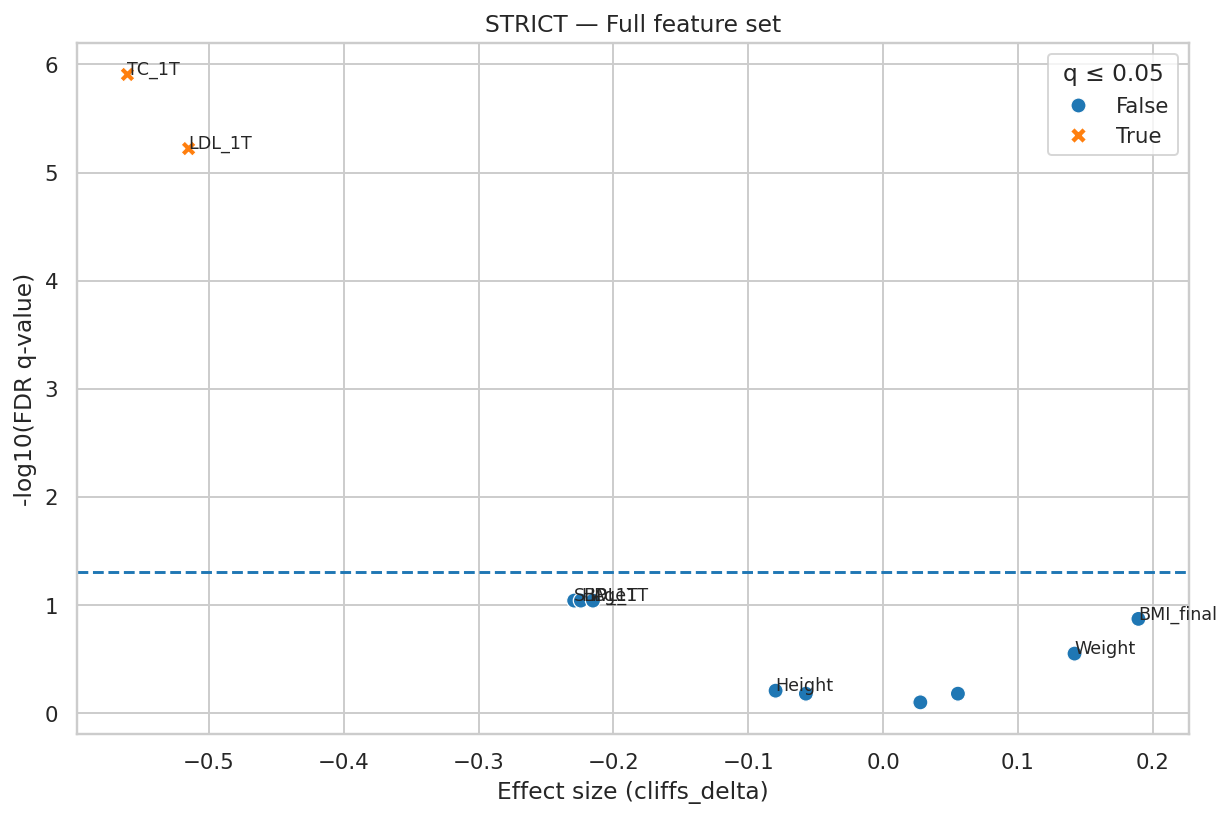

Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/group_comparisons/volcano_strict_full.png


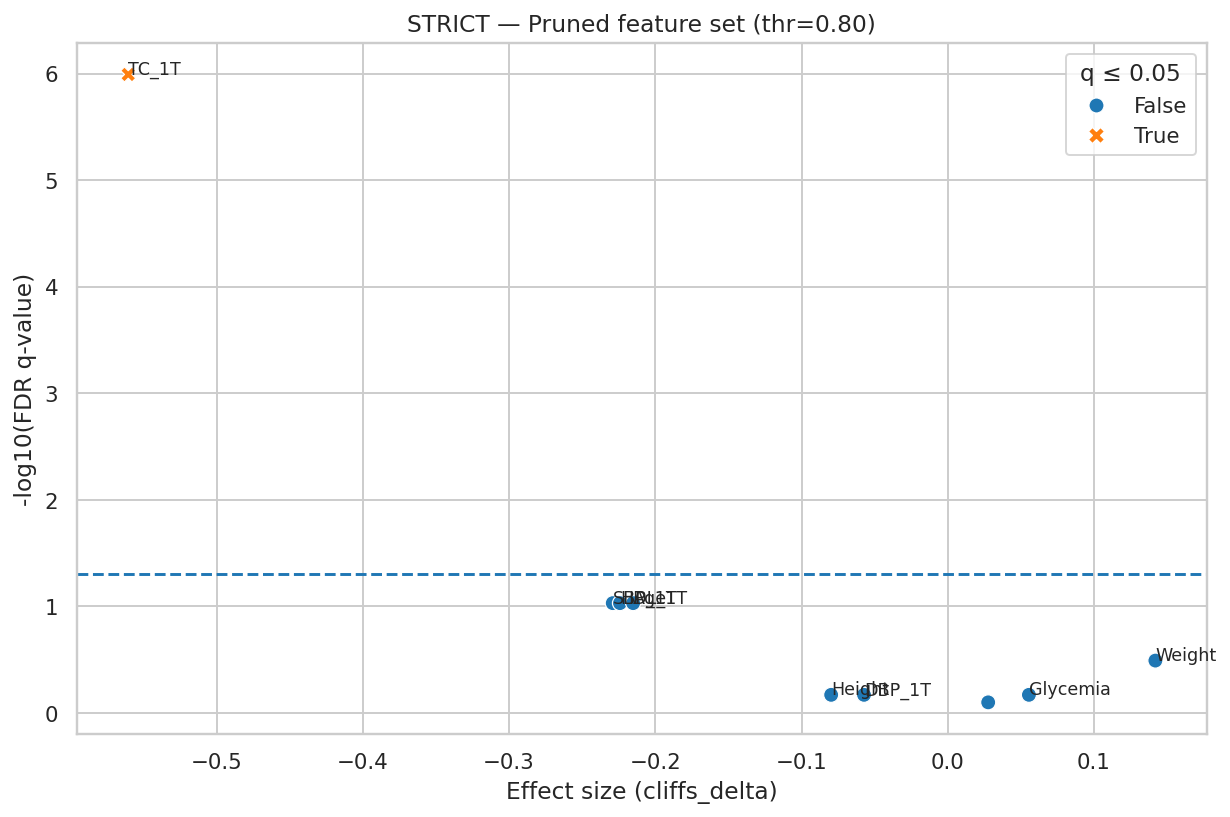

Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/group_comparisons/volcano_strict_pruned_thr0.80.png


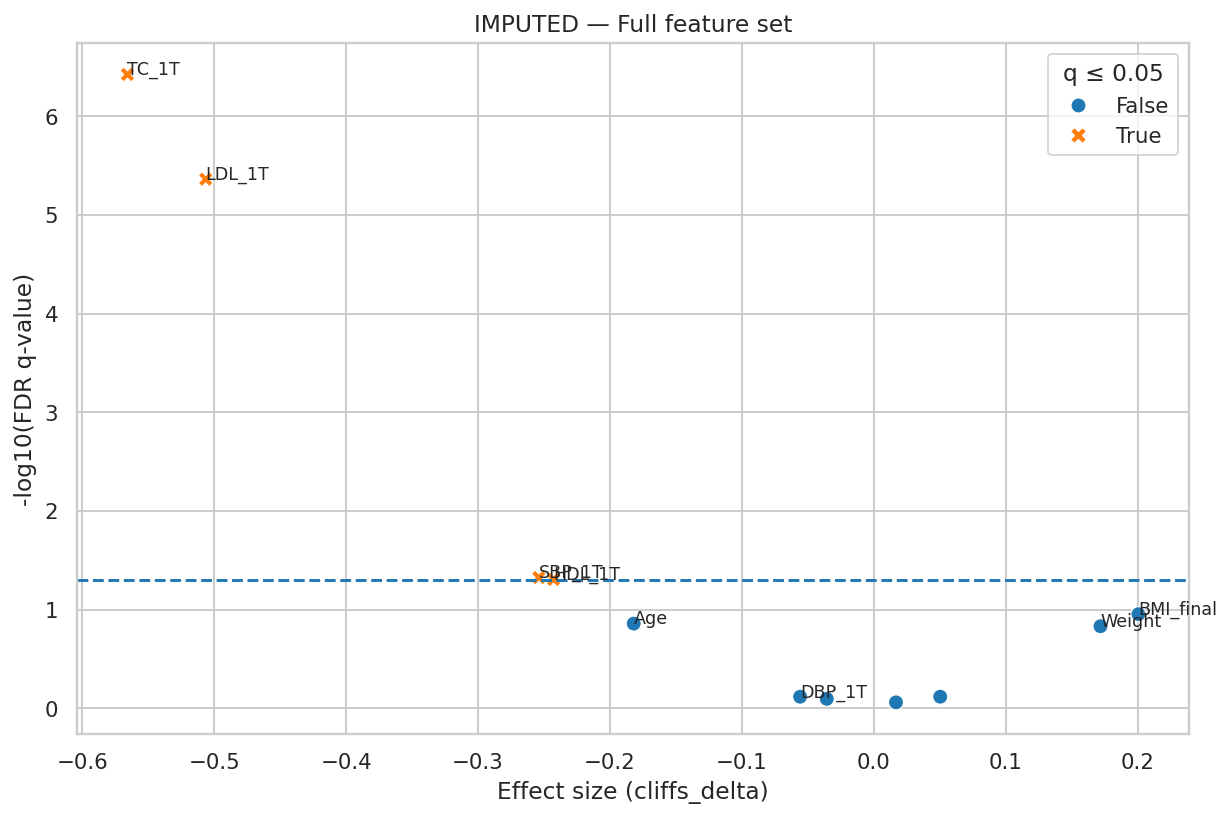

Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/group_comparisons/volcano_imputed_full.png


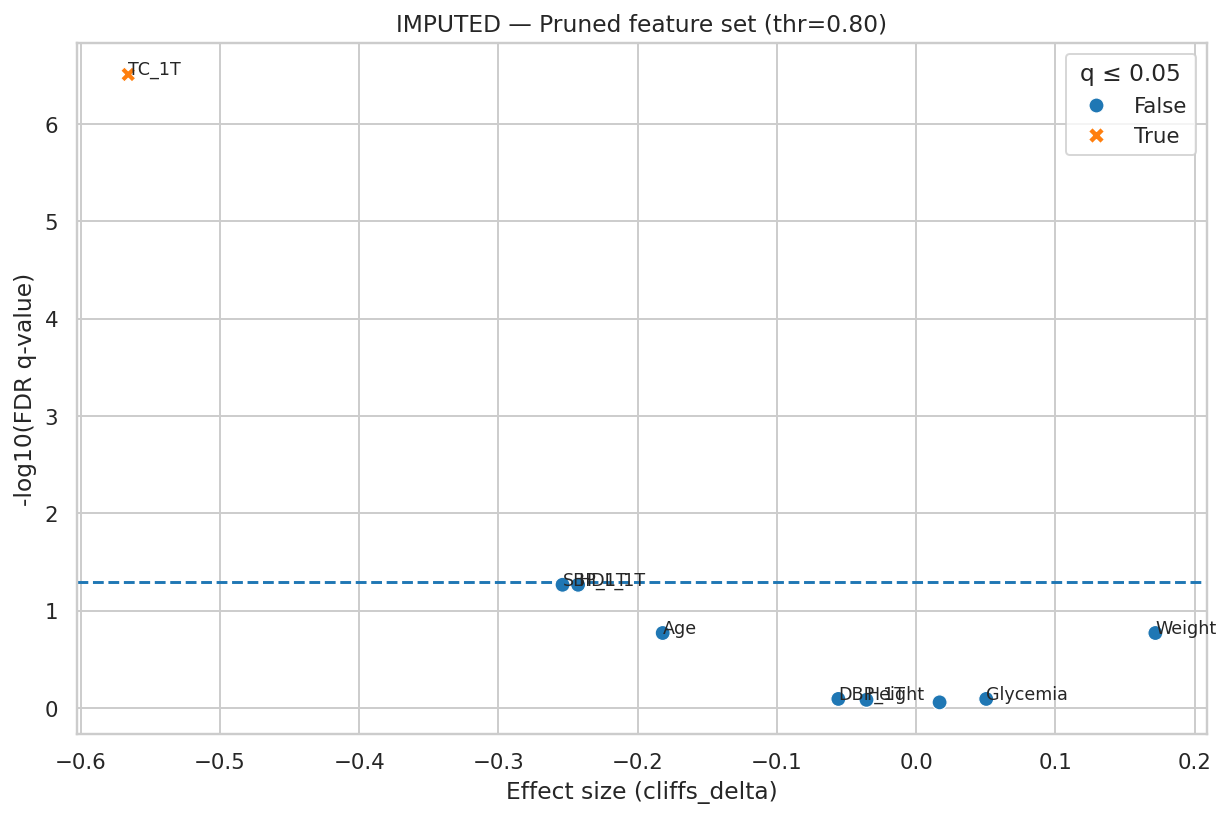

Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/group_comparisons/volcano_imputed_pruned_thr0.80.png


In [10]:
def volcano_plot(
    res: pd.DataFrame,
    title: str,
    outpath: Path,
    q_thresh: float = 0.05,
    top_label_n: int = 8,
) -> None:
    """
    Create a volcano-style plot:
    - x: effect size
    - y: -log10(q)

    Works best for 2-group setups (Cliff's delta). For multi-class, effect is epsilon².

    Parameters
    ----------
    res : pd.DataFrame
        Results table.
    title : str
        Plot title.
    outpath : Path
        Output image path.
    q_thresh : float
        FDR threshold for highlighting.
    top_label_n : int
        Number of top features (by q-value) to label.
    """
    dfp = res.copy()
    dfp["neglog10_q"] = -np.log10(dfp["q_value_fdr"].clip(lower=1e-300))
    dfp["is_sig"] = dfp["q_value_fdr"] <= q_thresh

    plt.figure(figsize=(9, 6))
    sns.scatterplot(data=dfp, x="effect", y="neglog10_q", hue="is_sig", style="is_sig", s=60)
    plt.axhline(-np.log10(q_thresh), linestyle="--")
    plt.title(title)
    plt.xlabel(f"Effect size ({dfp['effect_name'].iloc[0] if len(dfp) else 'effect'})")
    plt.ylabel("-log10(FDR q-value)")
    plt.legend(title=f"q ≤ {q_thresh}", loc="best")

    # label top features
    top = dfp.sort_values("q_value_fdr", ascending=True).head(top_label_n)
    for _, r in top.iterrows():
        if np.isfinite(r["effect"]) and np.isfinite(r["neglog10_q"]):
            plt.text(r["effect"], r["neglog10_q"], str(r["feature"]), fontsize=9)

    plt.tight_layout()
    plt.savefig(outpath)
    plt.show()
    print("Saved:", outpath)


volcano_plot(res_strict_full, "STRICT — Full feature set", FIG_DIR / "volcano_strict_full.png")
volcano_plot(res_strict_pru,  "STRICT — Pruned feature set (thr=0.80)", FIG_DIR / "volcano_strict_pruned_thr0.80.png")

volcano_plot(res_imputed_full, "IMPUTED — Full feature set", FIG_DIR / "volcano_imputed_full.png")
volcano_plot(res_imputed_pru,  "IMPUTED — Pruned feature set (thr=0.80)", FIG_DIR / "volcano_imputed_pruned_thr0.80.png")


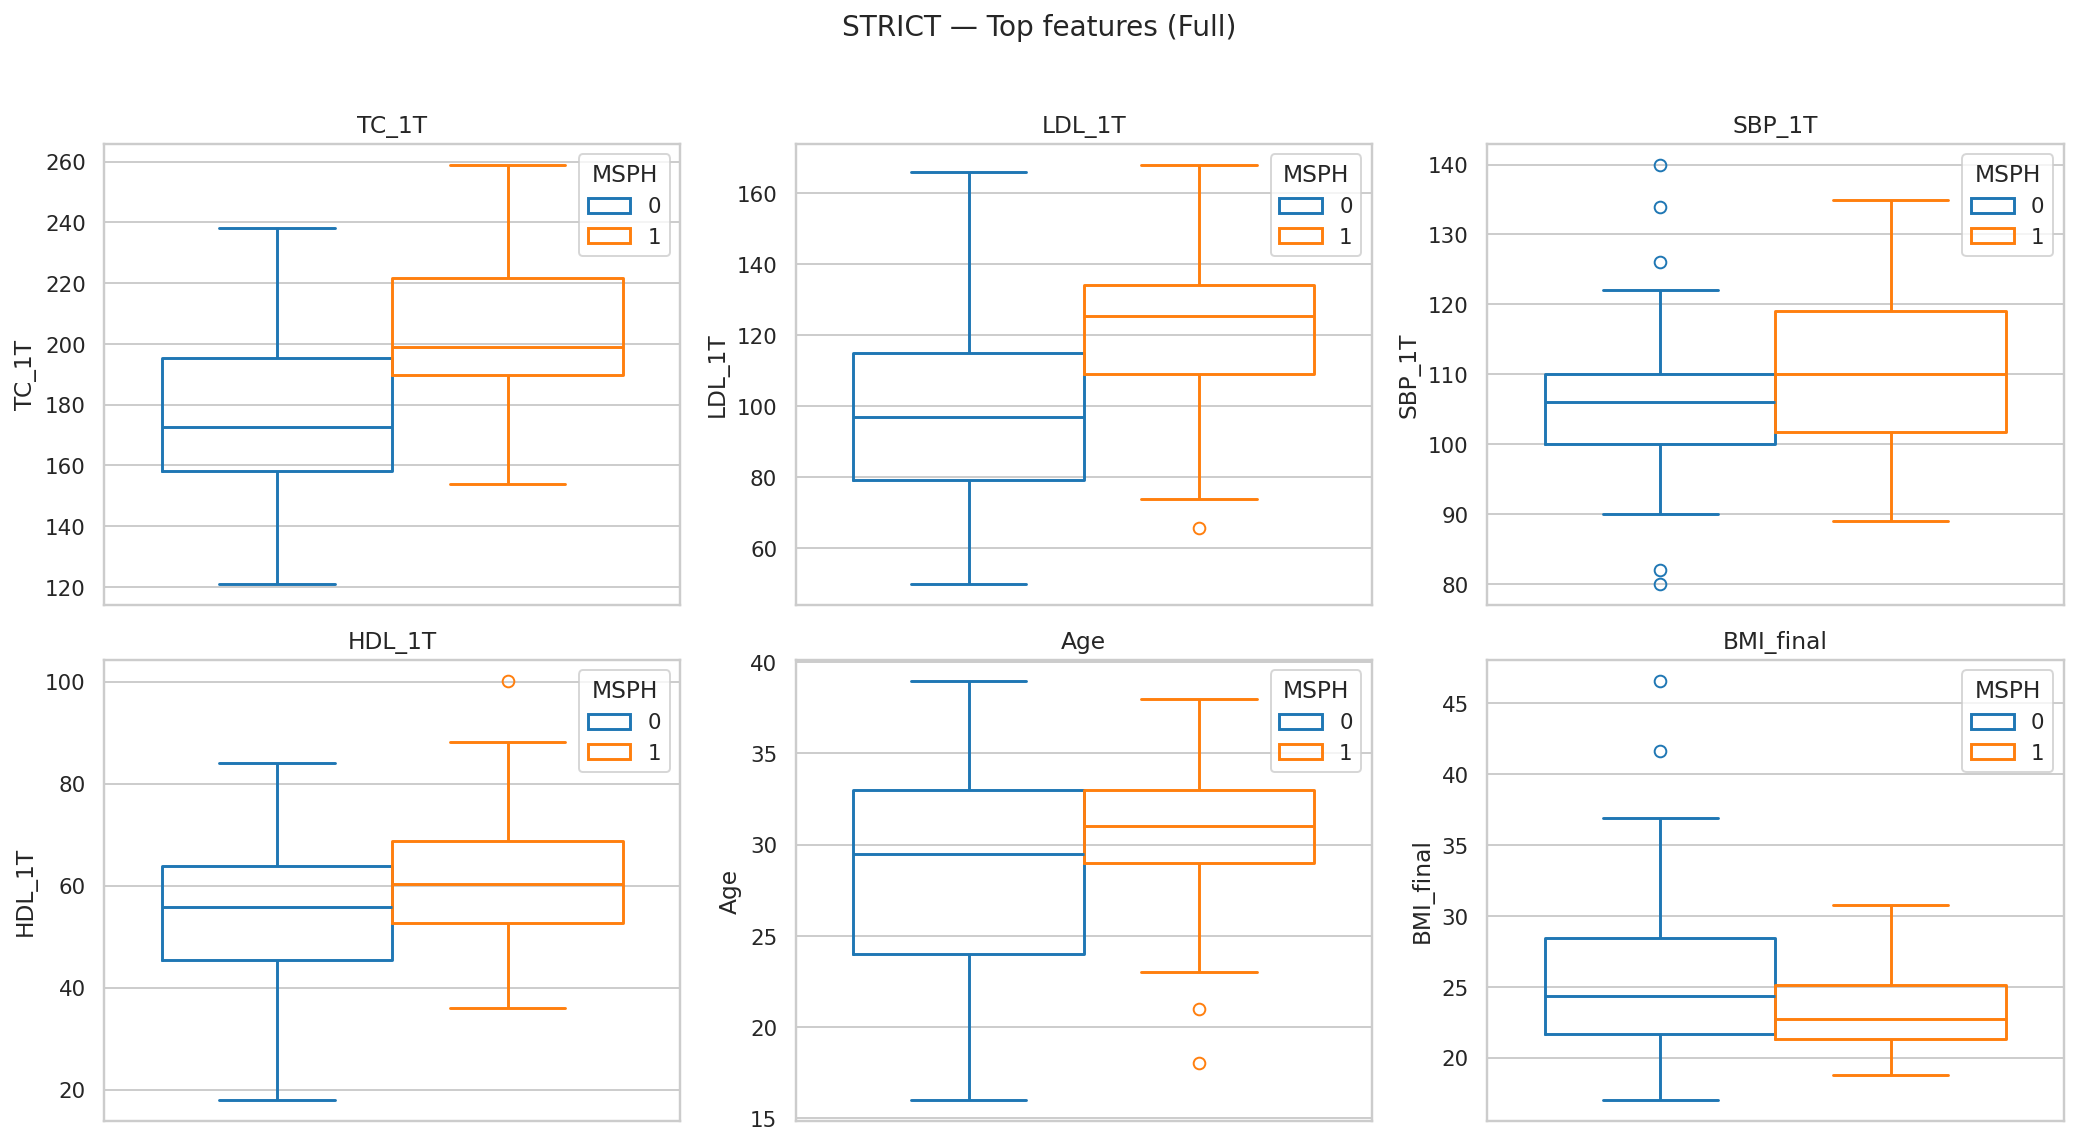

Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/group_comparisons/top_boxplots_strict_full.png


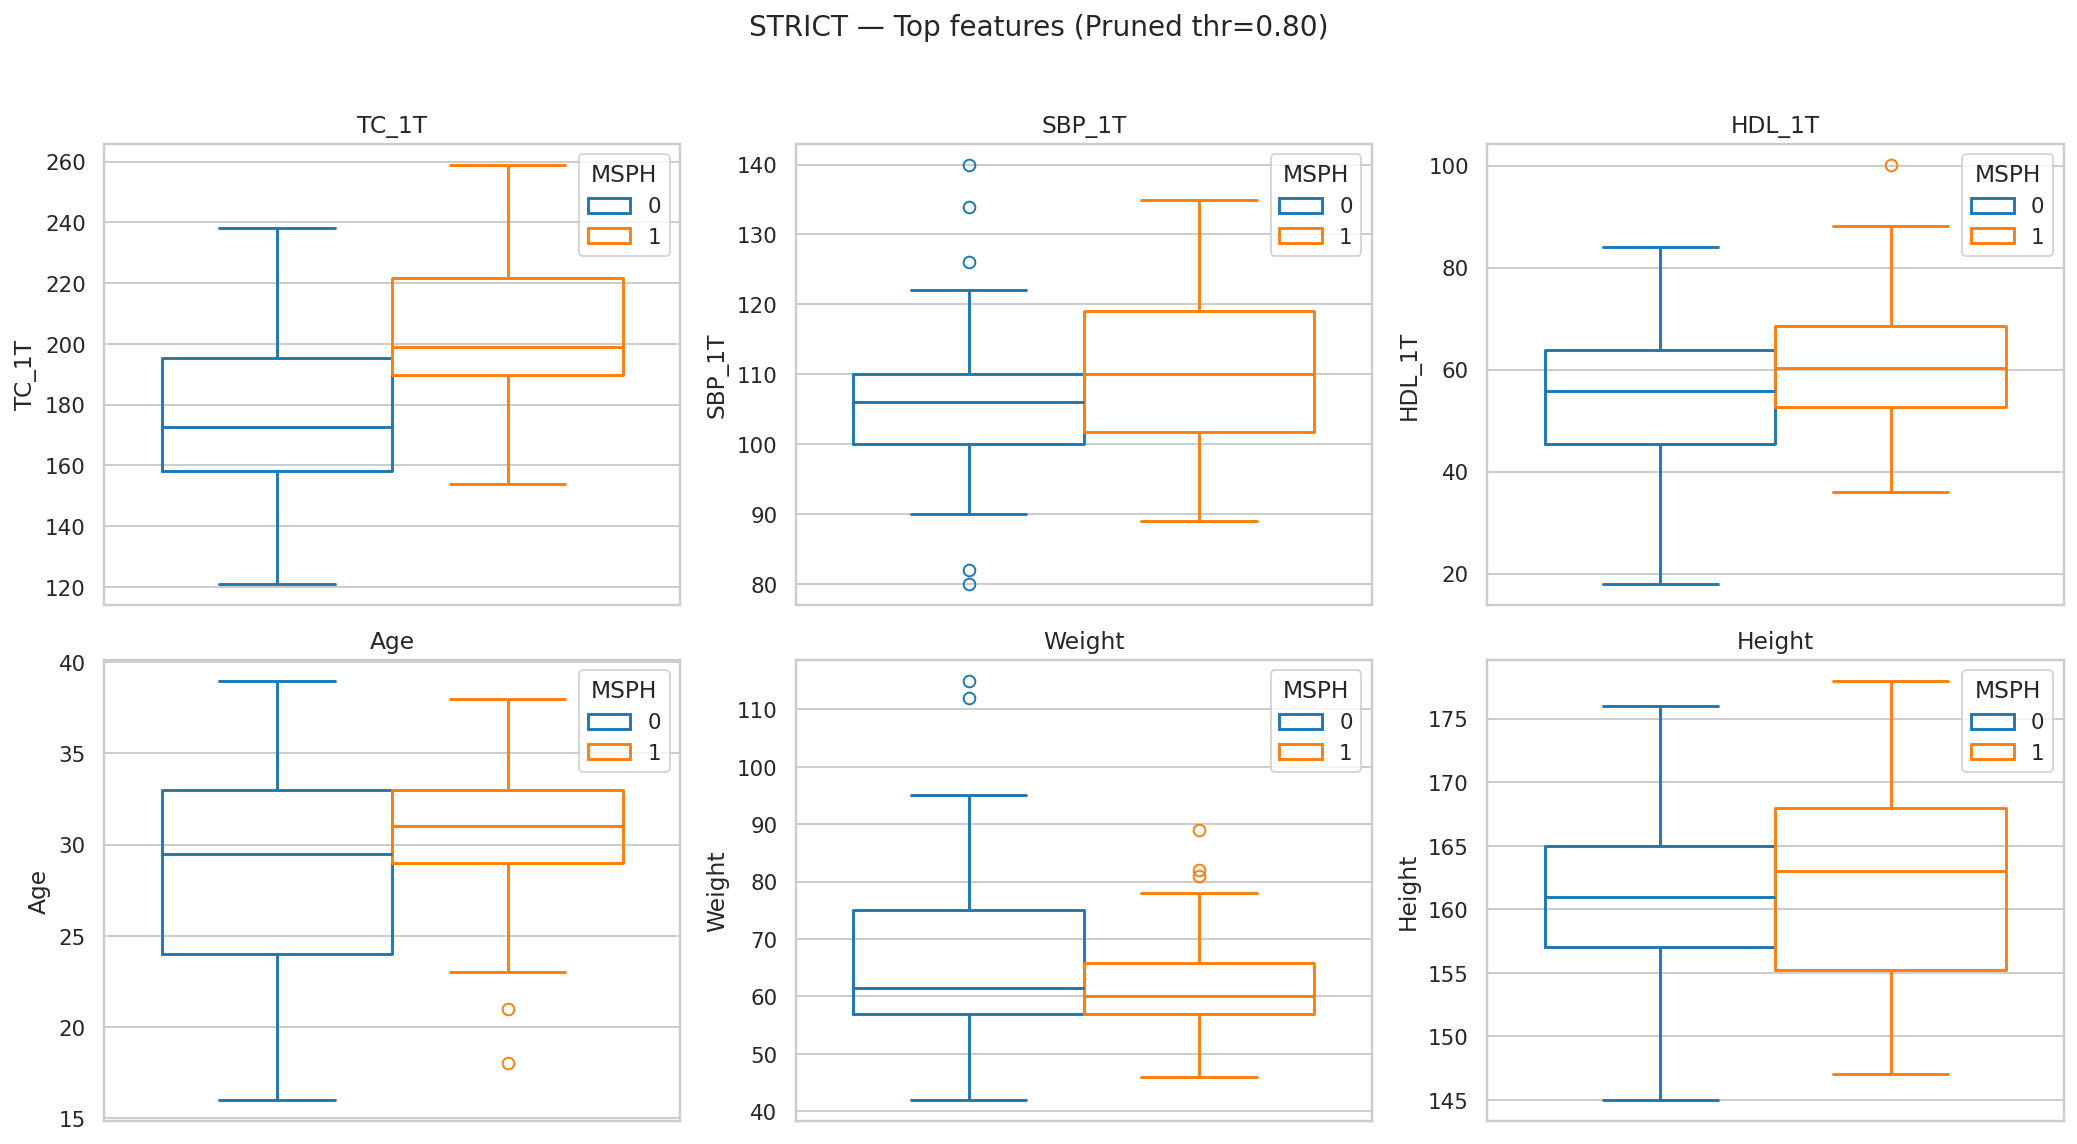

Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/group_comparisons/top_boxplots_strict_pruned_thr0.80.png


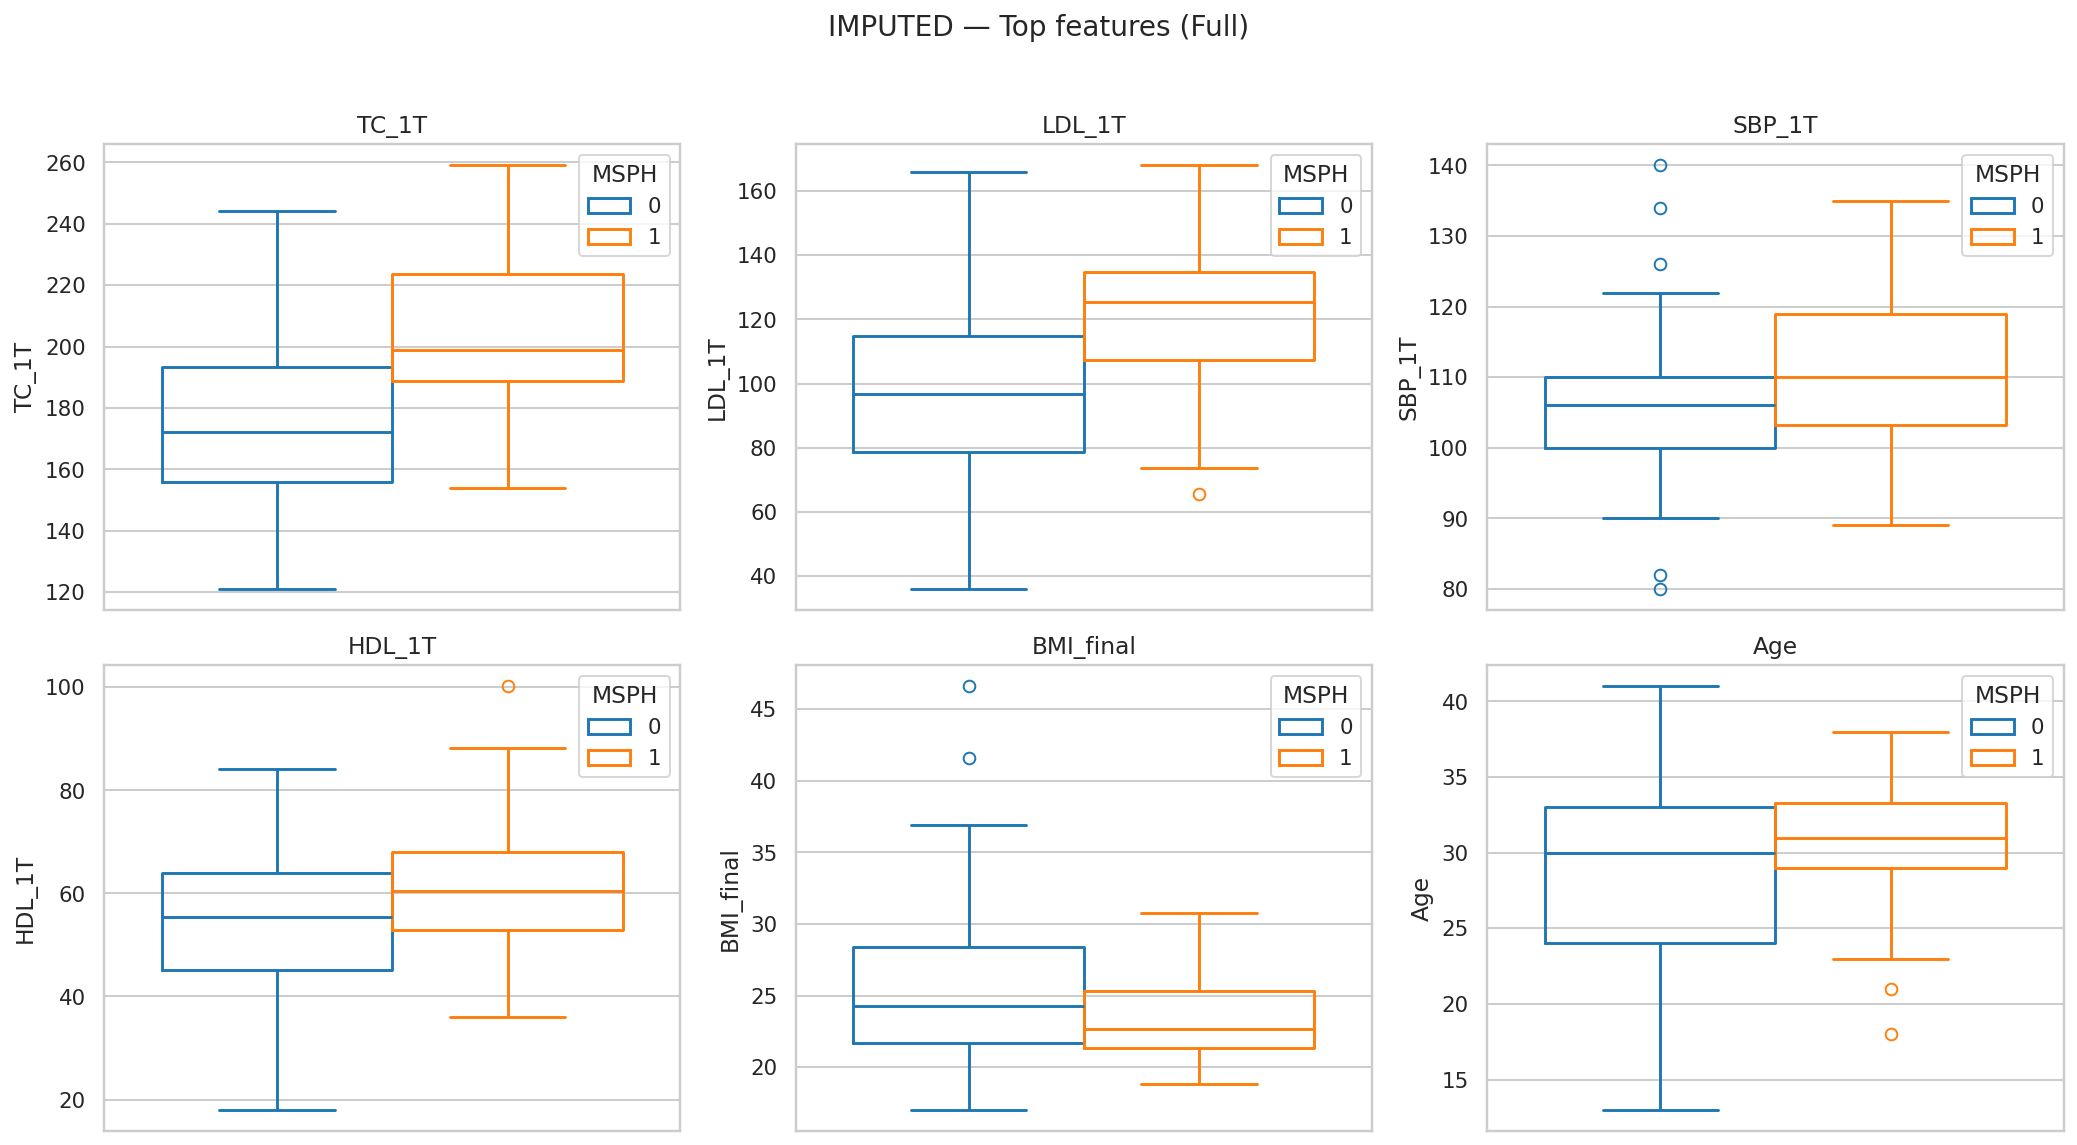

Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/group_comparisons/top_boxplots_imputed_full.png


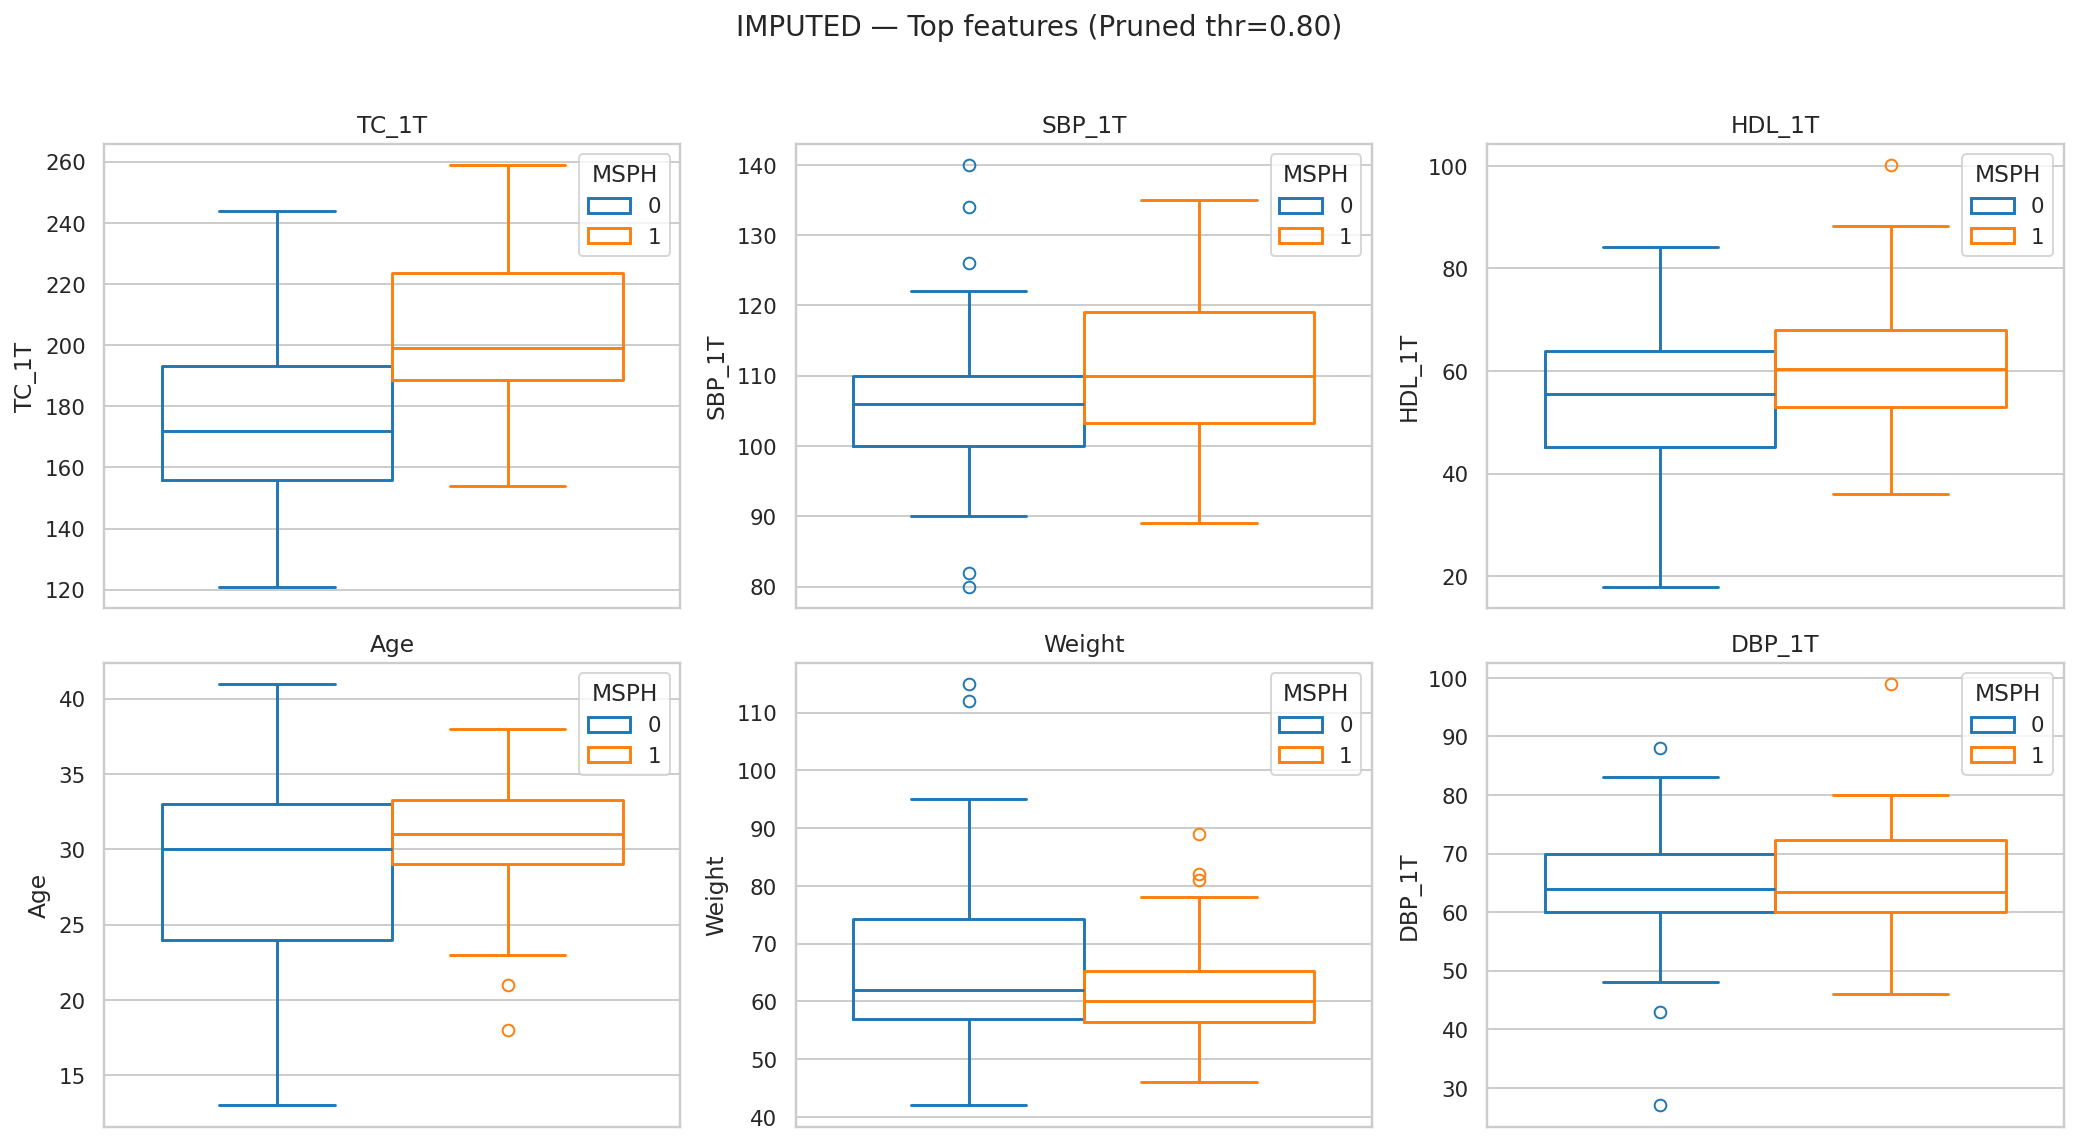

Saved: /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/figures/group_comparisons/top_boxplots_imputed_pruned_thr0.80.png


In [12]:
def top_features_boxplots(
    df: pd.DataFrame,
    res: pd.DataFrame,
    label_col: str,
    title: str,
    outpath: Path,
    top_k: int = 6,
) -> None:
    """
    Plot boxplots for the top-K features (lowest q-values).

    Parameters
    ----------
    df : pd.DataFrame
        Original dataset.
    res : pd.DataFrame
        Results table.
    label_col : str
        Label column.
    title : str
        Title.
    outpath : Path
        Output path.
    top_k : int
        Number of features.
    """
    top_feats = res.sort_values("q_value_fdr", ascending=True)["feature"].head(top_k).tolist()
    top_feats = [f for f in top_feats if f in df.columns]

    if not top_feats:
        print("No features to plot.")
        return

    ncols = 3
    nrows = int(np.ceil(len(top_feats) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
    axes = np.array(axes).reshape(-1)

    for ax, f in zip(axes, top_feats):
        tmp = df[[label_col, f]].copy()
        tmp[f] = pd.to_numeric(tmp[f], errors="coerce")
        tmp = tmp.dropna()

        sns.boxplot(data=tmp, hue=label_col, fill=False, y=f, ax=ax, showfliers=True)
        ax.set_title(f)

    for ax in axes[len(top_feats):]:
        ax.axis("off")

    fig.suptitle(title, y=1.02)
    fig.tight_layout()
    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved:", outpath)


top_features_boxplots(df_strict, res_strict_full, label_s, "STRICT — Top features (Full)", FIG_DIR / "top_boxplots_strict_full.png")
top_features_boxplots(df_strict, res_strict_pru,  label_s, "STRICT — Top features (Pruned thr=0.80)", FIG_DIR / "top_boxplots_strict_pruned_thr0.80.png")

top_features_boxplots(df_imputed, res_imputed_full, label_i, "IMPUTED — Top features (Full)", FIG_DIR / "top_boxplots_imputed_full.png")
top_features_boxplots(df_imputed, res_imputed_pru,  label_i, "IMPUTED — Top features (Pruned thr=0.80)", FIG_DIR / "top_boxplots_imputed_pruned_thr0.80.png")

In [13]:
def extract_significant_features(
    res: pd.DataFrame,
    q_thresh: float = 0.05,
) -> pd.DataFrame:
    """
    Extract significant features from a results table.

    Parameters
    ----------
    res : pd.DataFrame
        Results table from run_group_comparisons.
    q_thresh : float
        FDR threshold.

    Returns
    -------
    pd.DataFrame
        Subset of results with q_value_fdr <= q_thresh.
    """
    return res.loc[res["q_value_fdr"] <= q_thresh].copy()


def build_robust_hits(
    res_strict: pd.DataFrame,
    res_imputed: pd.DataFrame,
    label: str,
    q_thresh: float = 0.05,
) -> pd.DataFrame:
    """
    Build a robust-hits table: features significant in both strict and imputed datasets.

    Parameters
    ----------
    res_strict : pd.DataFrame
        Results from strict dataset.
    res_imputed : pd.DataFrame
        Results from imputed dataset.
    label : str
        Identifier label (e.g., 'full', 'pruned_thr0.80').
    q_thresh : float
        FDR threshold.

    Returns
    -------
    pd.DataFrame
        Robust hits table.
    """
    sig_s = extract_significant_features(res_strict, q_thresh)
    sig_i = extract_significant_features(res_imputed, q_thresh)

    # inner join on feature
    merged = sig_s.merge(
        sig_i,
        on="feature",
        suffixes=("_strict", "_imputed"),
        how="inner",
    )

    if merged.empty:
        return pd.DataFrame()

    # build compact summary
    out = pd.DataFrame({
        "feature": merged["feature"],
        "analysis_set": label,
        "effect_strict": merged["effect_strict"],
        "effect_imputed": merged["effect_imputed"],
        "effect_mean": merged[["effect_strict", "effect_imputed"]].mean(axis=1),
        "q_strict": merged["q_value_fdr_strict"],
        "q_imputed": merged["q_value_fdr_imputed"],
        "max_q": merged[["q_value_fdr_strict", "q_value_fdr_imputed"]].max(axis=1),
        "test": merged["test_strict"],
        "effect_name": merged["effect_name_strict"],
        "n_strict": merged["n_strict"],
        "n_imputed": merged["n_imputed"],
    })

    # rank by robustness (lower max_q, larger absolute effect)
    out["abs_effect_mean"] = out["effect_mean"].abs()
    out = out.sort_values(
        ["max_q", "abs_effect_mean"],
        ascending=[True, False],
    ).reset_index(drop=True)

    return out


# ----------------------------
# Build robust hit tables
# ----------------------------
ROBUST_Q = 0.05

robust_full = build_robust_hits(
    res_strict_full,
    res_imputed_full,
    label="full",
    q_thresh=ROBUST_Q,
)

robust_pruned = build_robust_hits(
    res_strict_pru,
    res_imputed_pru,
    label="pruned_thr0.80",
    q_thresh=ROBUST_Q,
)

display(robust_full)
display(robust_pruned)

# ----------------------------
# Export
# ----------------------------
robust_full_path = STATS_DIR / "robust_hits_full_q0.05.csv"
robust_pruned_path = STATS_DIR / "robust_hits_pruned_thr0.80_q0.05.csv"

robust_full.to_csv(robust_full_path, index=False)
robust_pruned.to_csv(robust_pruned_path, index=False)

print("Saved robust hit tables:")
print(" -", robust_full_path)
print(" -", robust_pruned_path)


,feature,analysis_set,effect_strict,effect_imputed,effect_mean,q_strict,q_imputed,max_q,test,effect_name,n_strict,n_imputed,abs_effect_mean
0,TC_1T,full,-0.560422,-0.565831,-0.563127,0.000001,3.781752e-07,0.000001,mannwhitneyu,cliffs_delta,148,160,0.563127
1,LDL_1T,full,-0.515049,-0.506466,-0.510757,0.000006,4.354668e-06,0.000006,mannwhitneyu,cliffs_delta,148,160,0.510757


,feature,analysis_set,effect_strict,effect_imputed,effect_mean,q_strict,q_imputed,max_q,test,effect_name,n_strict,n_imputed,abs_effect_mean
0,TC_1T,pruned_thr0.80,-0.560422,-0.565831,-0.563127,0.000001,3.094161e-07,0.000001,mannwhitneyu,cliffs_delta,148,160,0.563127


Saved robust hit tables:
 - /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/stats/robust_hits_full_q0.05.csv
 - /home/david/Desktop/colabs/serra_ramon/hypercholesterolemia_classifiers/results/eda/stats/robust_hits_pruned_thr0.80_q0.05.csv


## How to interpret Full vs Pruned

- If pruning reduces the number of tests, FDR often becomes slightly less strict.
- Ideally:
  - The same top signals appear in both Full and Pruned (robustness).
  - Pruned removes redundancy but does not change conclusions.

Recommended reporting:
- Main text: use the Full set (transparency) + note redundancy check
- Supplement: show that Pruned yields consistent top findings (robustness check)
